In [1]:
from attention import *
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [2]:
import pandas as pd

df = pd.read_json('aspen.json')

df

,stars,hotel,title,content
0,5,[Limelight Hotel],[Awesome visit ],[Went on a girls trip this past weekend. We ha...
1,5,[Limelight Hotel],[Super hotel and Super Staff],[We were very lucky to win 4 nights accomodati...
2,5,[Chateau Roaring Fork],[Wait until the last minute],[Wait until the last minute and get a lodging/...
3,5,[Limelight Hotel],[Great Hotel. Nice place to stay],[Great hotel. Beautiful. Great well decorated ...
4,3,[Aspen Mountain Lodge],[Quaint and cozy lodge],"[Great value, decent location. I'd highly reco..."
...,...,...,...,...
2001,5,[Chateau Blanc],[Great stay],[Spent a couple of nights in Aspen on a girls ...
2002,4,[Chateau Blanc],[Excellent cost/benefit],[We stayed in a two bedrooms/bathrooms apartme...
2003,5,[Chateau Blanc],[Great WInter Vaca],[A wonderful place to stay for our family vaca...
2004,5,[Chateau Blanc],[Chateau Blanc for a week],[The lodge is few blocks away from the main do...


In [3]:
# Define a function to categorize stars
def categorize_stars(stars):
    if stars in [4, 5]:
        return 1
    elif stars in [1, 2,3]:
        return 0
    else:
        return 'Unknown'

# Read your DataFrame from the provided data
# df = pd.read_csv('your_data.csv')  # Uncomment and replace 'your_data.csv' with your file path if you're reading from a CSV file

# Apply the categorize_stars function to the 'stars' column and create a new column 'rating'
df['rating'] = df['stars'].apply(categorize_stars)
df

,stars,hotel,title,content,rating
0,5,[Limelight Hotel],[Awesome visit ],[Went on a girls trip this past weekend. We ha...,1
1,5,[Limelight Hotel],[Super hotel and Super Staff],[We were very lucky to win 4 nights accomodati...,1
2,5,[Chateau Roaring Fork],[Wait until the last minute],[Wait until the last minute and get a lodging/...,1
3,5,[Limelight Hotel],[Great Hotel. Nice place to stay],[Great hotel. Beautiful. Great well decorated ...,1
4,3,[Aspen Mountain Lodge],[Quaint and cozy lodge],"[Great value, decent location. I'd highly reco...",0
...,...,...,...,...,...
2001,5,[Chateau Blanc],[Great stay],[Spent a couple of nights in Aspen on a girls ...,1
2002,4,[Chateau Blanc],[Excellent cost/benefit],[We stayed in a two bedrooms/bathrooms apartme...,1
2003,5,[Chateau Blanc],[Great WInter Vaca],[A wonderful place to stay for our family vaca...,1
2004,5,[Chateau Blanc],[Chateau Blanc for a week],[The lodge is few blocks away from the main do...,1


In [4]:
import os
import sys
import numpy as np

import string
import re

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [5]:
def clean_text(str_list, lemmatize=True):
    clean_list = []
    
    for text in str_list:
        # Remove pound sign from hashtags
        text = re.sub(r'#', '', text)
        words = word_tokenize(text)
        clean_words = []
        
        lemmatizer = WordNetLemmatizer()  # Move lemmatizer initialization outside the loop
        
        for word in words:
            # Drop words with fewer than 2 characters and drop any punctuation "words"
            if len(word) > 1 and re.match(r'^\w+$', word):
                if lemmatize:
                    word = lemmatizer.lemmatize(word)  # Apply lemmatization
                clean_words.append(word)
        
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [6]:
df['content'] = df['content'].astype(str)
df['clean_text']= clean_text(df['content'])
df['clean_text']= df['clean_text'].str.lower()
df

,stars,hotel,title,content,rating,clean_text
0,5,[Limelight Hotel],[Awesome visit ],['Went on a girls trip this past weekend. We h...,1,on girl trip this past weekend we had wonderfu...
1,5,[Limelight Hotel],[Super hotel and Super Staff],['We were very lucky to win 4 nights accomodat...,1,were very lucky to win night accomodation at t...
2,5,[Chateau Roaring Fork],[Wait until the last minute],"[""Wait until the last minute and get a lodging...",1,wait until the last minute and get ticket pack...
3,5,[Limelight Hotel],[Great Hotel. Nice place to stay],['Great hotel. Beautiful. Great well decorated...,1,hotel beautiful great well decorated bar and n...
4,3,[Aspen Mountain Lodge],[Quaint and cozy lodge],"[""Great value, decent location. I'd highly rec...",0,great value decent location highly recommend r...
...,...,...,...,...,...,...
2001,5,[Chateau Blanc],[Great stay],['Spent a couple of nights in Aspen on a girls...,1,couple of night in aspen on girl getaway our t...
2002,4,[Chateau Blanc],[Excellent cost/benefit],['We stayed in a two bedrooms/bathrooms apartm...,1,stayed in two apartment the apartment had pret...
2003,5,[Chateau Blanc],[Great WInter Vaca],['A wonderful place to stay for our family vac...,1,wonderful place to stay for our family vacatio...
2004,5,[Chateau Blanc],[Chateau Blanc for a week],"[""The lodge is few blocks away from the main d...",1,the lodge is few block away from the main down...


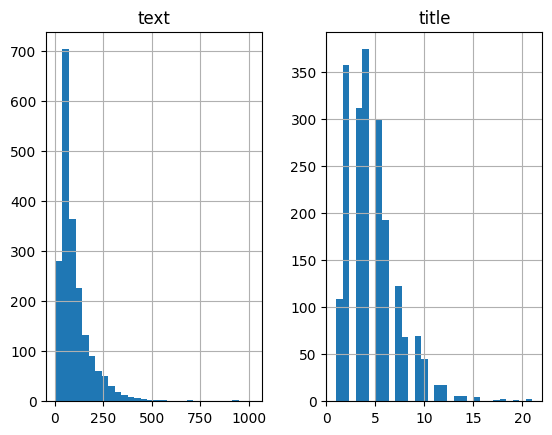

In [7]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['clean_text']:
    text_word_count.append(len(i.split()))

for i in df['title']:
    # Check if i is a list, and join its elements into a single string
    if isinstance(i, list):
        i = ' '.join(i)
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'title': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [8]:
max_len_text = 100  
max_len_summary = 4

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['clean_text'], df['title'], test_size=0.2, random_state=0, shuffle=True)

# Convert numpy arrays to lists of strings
X_train_list = [str(sentence) for sentence in X_train]
X_val_list = [str(sentence) for sentence in X_val]
y_train_list = [str(sentence) for sentence in y_train]
y_val_list = [str(sentence) for sentence in y_val]

# Define and fit tokenizer on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train_list)

# Convert summary sequences into integer sequences
y_train_seq = y_tokenizer.texts_to_sequences(y_train_list)
y_val_seq = y_tokenizer.texts_to_sequences(y_val_list)

# Padding zero up to maximum length
y_train_pad = pad_sequences(y_train_seq, maxlen=max_len_text, padding='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

In [10]:
from keras.layers import Layer
import tensorflow as tf

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_outputs, decoder_outputs = inputs
        score = tf.matmul(decoder_outputs, encoder_outputs, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context_vector = tf.matmul(attention_weights, encoder_outputs)
        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        batch_size, dec_seq_len, latent_dim = input_shape[1]
        enc_seq_len = input_shape[0][1]
        return [(batch_size, dec_seq_len, latent_dim), (batch_size, dec_seq_len, enc_seq_len)]

In [11]:
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras.models import Model

latent_dim = 500

tokenizer_x = Tokenizer()
tokenizer_x.fit_on_texts(X_train)

x_voc_size = len(tokenizer_x.word_index) + 1

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = Dense(y_voc_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 100, 500)          │       3,742,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 100, 500), (None, │       2,002,000 │ embedding[0][0]            │
│                               │ 500), (None, 500)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 100, 500), (None, │       2,002,000 │ lstm[0][0]                 │
│                               │ 500), (None, 500)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 500)         │         886,000 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ [(None, 100, 500), (None, │       2,002,000 │ lstm_1[0][0]               │
│                               │ 500), (None, 500)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ [(None, None, 500),       │       2,002,000 │ embedding_1[0][0],         │
│                               │ (None, 500), (None, 500)] │                 │ lstm_2[0][1], lstm_2[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer               │ [(None, None, 500),       │               0 │ lstm_2[0][0], lstm_3[0][0] │
│ (AttentionLayer)              │ (None, None, 100)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat_layer (Concatenate)    │ (None, None, 1000)        │               0 │ lstm_3[0][0],              │
│                               │                           │                 │ attention_layer[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 1772)        │       1,773,772 │ concat_layer[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,409,772 (54.97 MB)

 Trainable params: 14,409,772 (54.97 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [14]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=tokenizer_x.index_word 
target_word_index=y_tokenizer.word_index

In [15]:
# Define the encoder model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Define the decoder model inputs
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Define the decoder model embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)

# Define the decoder LSTM layer
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Define the attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Define the dense softmax layer
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Define the decoder model
decoder_model = Model(
    inputs=[decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs2, state_h2, state_c2]
)

In [16]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    if 'start' in target_word_index:
        target_seq[0, 0] = target_word_index['start']
    else:
        print("Warning: 'start' token not found in target_word_index. Using 0 as default.")
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length
        # or find stop word.
        if sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

target_word_index['start'] = len(target_word_index) + 1
target_word_index['end'] = len(target_word_index) + 2
    
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i in reverse_source_word_index:
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

for i, (text, summary) in enumerate(zip(X_val, y_val)):
    # Tokenize the text
    text_sequence = tokenizer_x.texts_to_sequences([text])[0]
    # Pad the sequence if needed
    text_padded = pad_sequences([text_sequence], maxlen=max_len_text, padding='post')
    
    print("Review:", seq2text(text_sequence))
    print("Predicted summary:", decode_sequence(text_padded))
    print("\n")

    if i == 19:
        break

Review: have stayed in many different place in aspen and usually look for condo this year we booked late and ended up here first it wa le money for two room than the other option we have had in the past the breakfast wa very nice the host wa friendly and happy to offer fresh quiche along with some basic bagel toast cereal etc as an included perk it wa very nice the wine and cooky offered were even better rooms were clean and the towel were plush hate bad towel the only draw back wa the distance a compared to other place closer to the gondola still our kid are teenager and the walk 10 minute wa no big deal in fact it wa nice little warm up and cool down for the day of skiing friendly staff and reasonable for aspen we will be back couldn leave without buying 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted summary:  friendliness west' down


Review: is review on the remede 